# Automate a shared bikes and scooters classification model with Amazon SageMaker Autopilot.

[Amazon SageMaker AutoPilot](https://aws.amazon.com/sagemaker/autopilot/) makes it possible for organizations to quickly build and deploy an end-to-end machine learning (ML) model and inference pipeline with just a few lines of code or even [without any code](https://docs.aws.amazon.com/sagemaker/latest/dg/autopilot-automate-model-development-create-experiment.html) at all with [Amazon SageMaker Studio.]https://docs.aws.amazon.com/sagemaker/latest/dg/studio.html Autopilot offloads the heavy lifting of configuring infrastructure and the time it takes to build an entire pipeline, including feature engineering, model selection, and hyperparameter tuning.

In this post, we show how to go from raw data to a robust and fully deployed inference pipeline with Autopilot.

## Solution overview

We use [Lyft's public dataset on bikesharing](https://www.lyft.com/bikes/bay-wheels/system-data) on bikesharing for this simulation to predict whether or not a user participates in the [Bike share for all program](https://www.lyft.com/bikes/bay-wheels/bike-share-for-all). This is a simple binary classification problem.

We want to showcase how easy it is to build an automated and real-time inference pipeline to classify users based on their participation in the Bike Share for All program. To this end, we simulate an end-to-end data ingestion and inference pipeline for an imaginary bikeshare company operating in the San Francisco Bay Area.

The architecture is broken down into two parts: the ingestion pipeline and the inference pipeline.

## Architecture

The architecture is broken down into two parts: the ingestion pipeline and the inference pipeline.

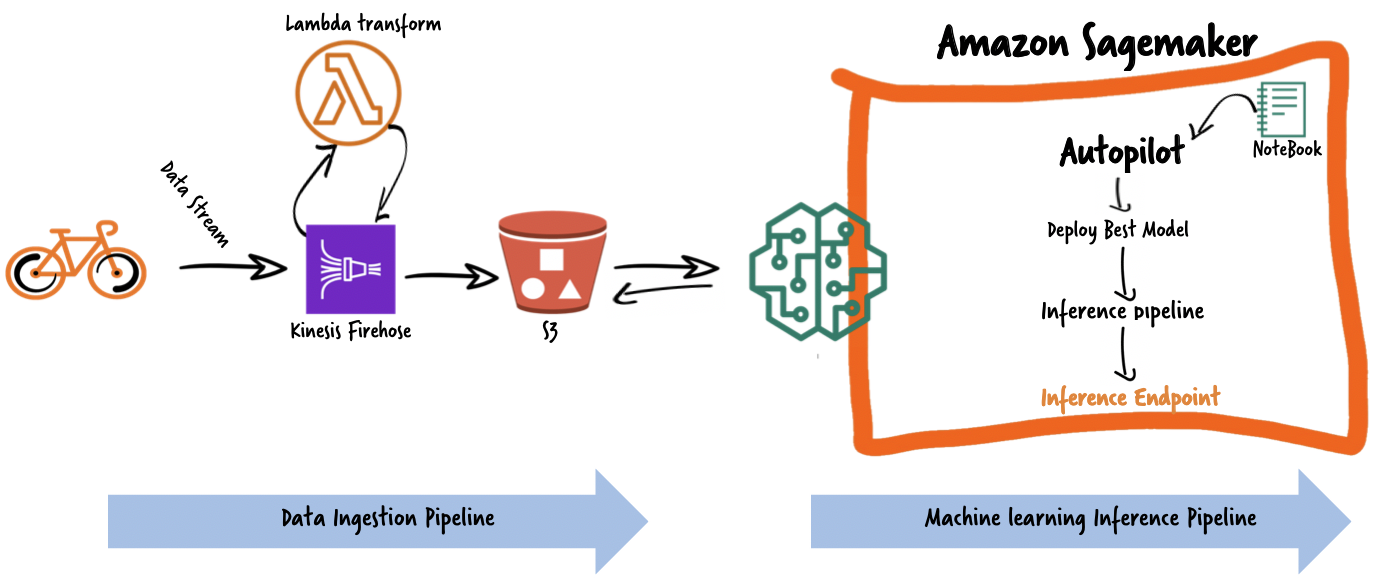

We primarily focus on the ML pipeline in the first section of this post, and review the data ingestion pipeline in the second part.

## Prerequisites

To follow along with this example, complete the following prerequisites:

1. Create a new [SageMaker notebook instance](https://docs.aws.amazon.com/sagemaker/latest/dg/gs-setup-working-env.html) following this procedure (Link here)
2. Create an [Amazon Kinesis firehose delivery](https://aws.amazon.com/blogs/compute/amazon-kinesis-firehose-data-transformation-with-aws-lambda/) stream with an [Lambda transform](http://aws.amazon.com/lambda) function. For instructions, see [Amazon Kinesis Firehose Data Transformation with AWS Lambda.](https://aws.amazon.com/blogs/compute/amazon-kinesis-firehose-data-transformation-with-aws-lambda/) This step is optional and only needed to simulate data streaming.


## Data exploration

Let’s download and visualize the dataset, which is located in a public [Amazon Simple Storage Service](http://aws.amazon.com/s3) (Amazon S3) bucket and static website:

In [ ]:
# The dataset is located in a public bucket and static s3 website.
# https://www.lyft.com/bikes/bay-wheels/system-data

import pandas as pd
import numpy as np
import os
from time import sleep

!wget -q -O '201907-baywheels-tripdata.zip' https://s3.amazonaws.com/baywheels-data/201907-baywheels-tripdata.csv.zip
!unzip -q -o 201907-baywheels-tripdata.zip
csv_file = os.listdir('.')
data = pd.read_csv('201907-baywheels-tripdata.csv', low_memory=False)
data.head()

The following screenshot shows a subset of the data before transformation.

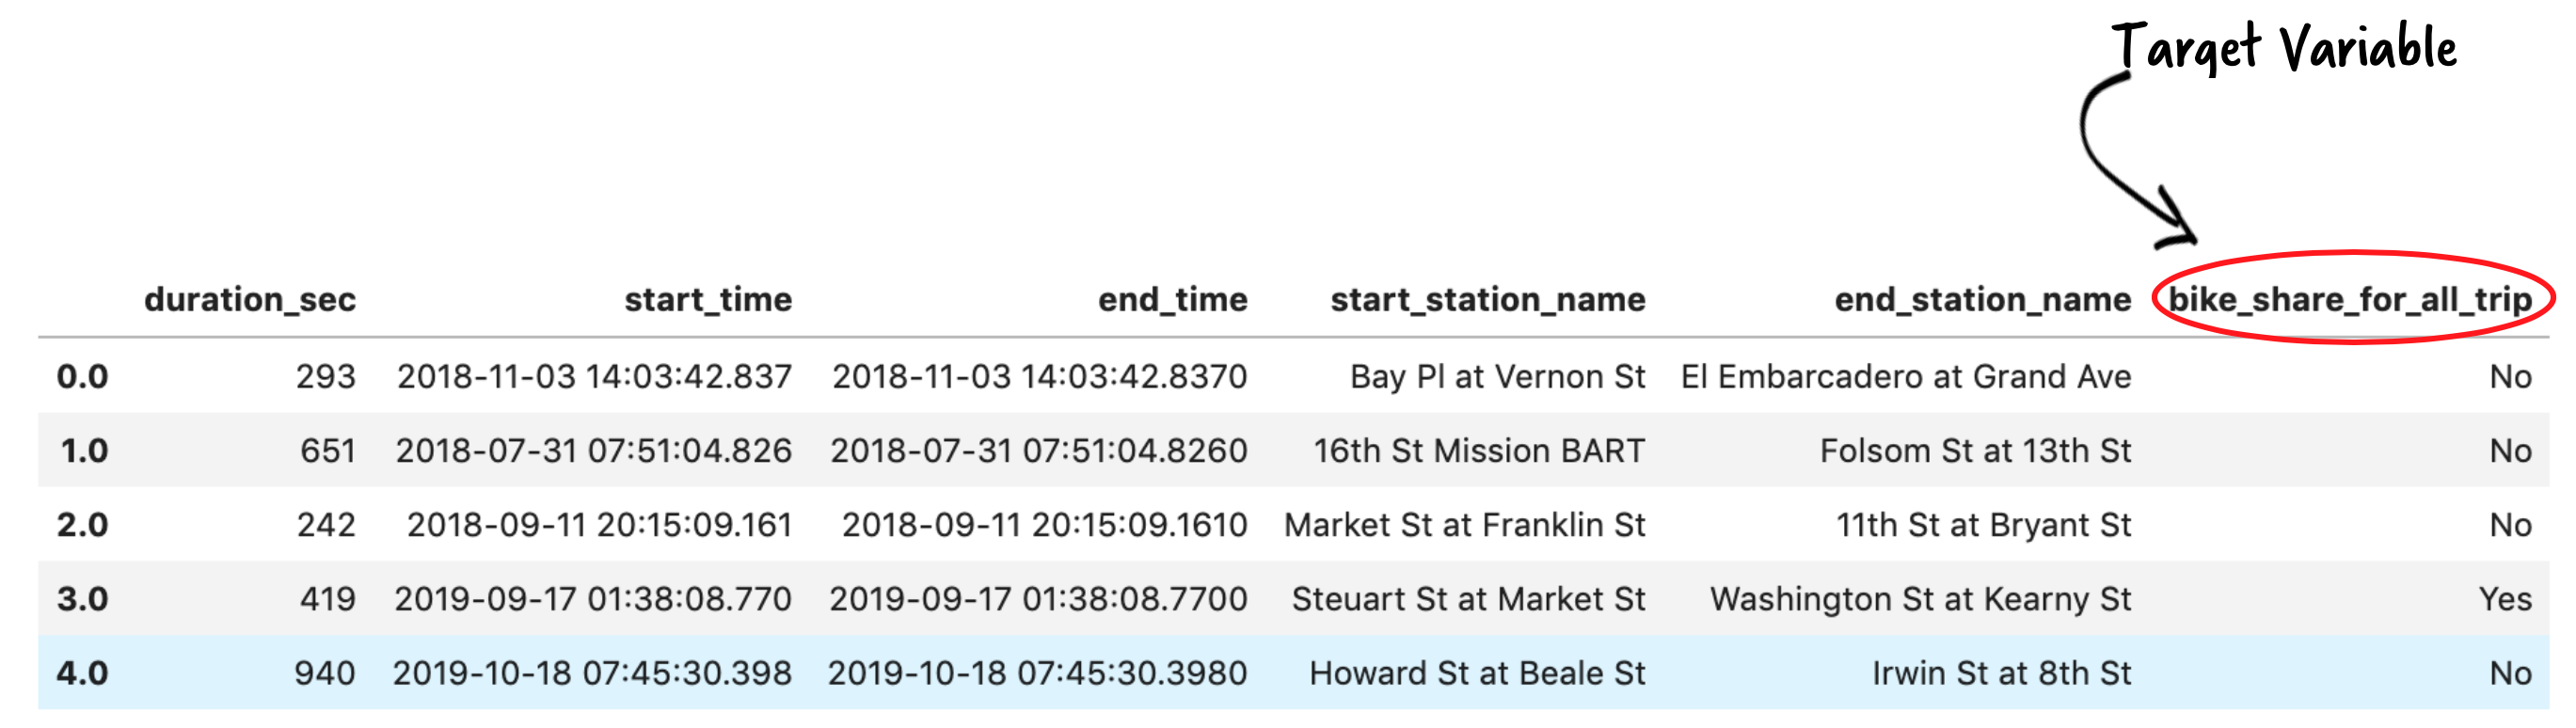

The last column of the data contains the target we want to predict, which is a binary variable taking either a Yes or No value, indicating whether the user participates in the Bike Share for All program.

Let’s take a look at the distribution of our target variable for any data imbalance.

In [ ]:
# For plotting
%matplotlib inline
import matplotlib.pyplot as plt
#!pip install seaborn # If you need this library
import seaborn as sns
display(sns.countplot(x='bike_share_for_all_trip', data=data))

As shown in the following graph, the data is imbalanced, with fewer people participating in the program.

We need to balance the data to prevent an over-representation bias. This step is optional because Autopilot also offers an internal approach to handle class imbalance automatically, which defaults to a F1 score validation metric. Additionally, if you choose to balance the data yourself, you can use more advanced techniques for handling class imbalance, such as [SMOTE](https://arxiv.org/abs/1106.1813) or [GAN](https://arxiv.org/abs/2008.09202).

For this post, we downsample the majority class (No) as a data balancing technique:

The following code enriches the data and under-samples the overrepresented class: 

In [ ]:
df = data.copy()
df.drop(columns=['rental_access_method'], inplace=True)

df['start_time'] = pd.to_datetime(df['start_time'])
df['start_time'] = pd.to_datetime(df['end_time'])

# Adding some day breakdown
df = df.assign(day_of_week=df.start_time.dt.dayofweek,
                            hour_of_day=df.start_time.dt.hour,
                            trip_month=df.start_time.dt.month)
# Breaking the day in 4 parts: ['morning', 'afternoon', 'evening']
conditions = [
    (df['hour_of_day'] >= 5) & (df['hour_of_day'] < 12),
    (df['hour_of_day'] >= 12) & (df['hour_of_day'] < 18),
    (df['hour_of_day'] >= 18) & (df['hour_of_day'] < 21),
]
choices = ['morning', 'afternoon', 'evening']
df['part_of_day'] = np.select(conditions, choices, default='night')
df.dropna(inplace=True)

# Downsampling the majority to rebalance the data
# We are getting about an even distribution
df.sort_values(by='bike_share_for_all_trip', inplace=True)
slice_pointe = int(df['bike_share_for_all_trip'].value_counts()['Yes'] * 2.1)
df = df[-slice_pointe:]
# The data is balanced now. Let's reshuffle the data
df = df.sample(frac=1).reset_index(drop=True)

We deliberately left our categorical features not encoded, including our binary target value. This is because Autopilot takes care of encoding and decoding the data for us as part of the automatic feature engineering and pipeline deployment, as we see in the next section.

The following screenshot shows a sample of our data.

![image(3).png](attachment:image(3).png)
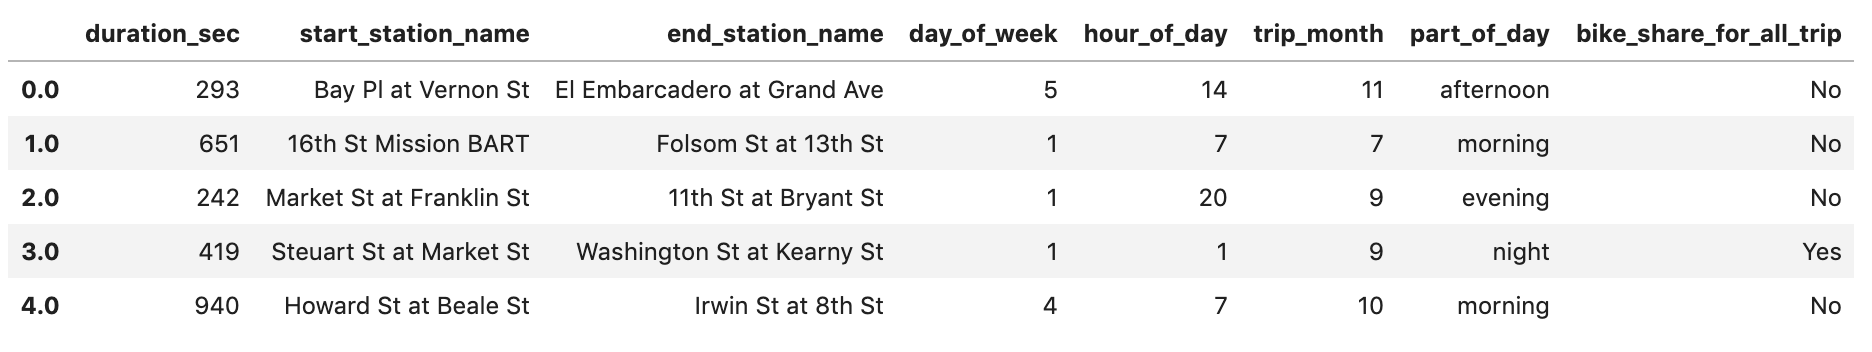

The data in the following graphs looks otherwise normal, with a bimodal distribution representing the two peaks for the morning hours and the afternoon rush hours, as you would expect. We also observe low activities on weekends and at night.

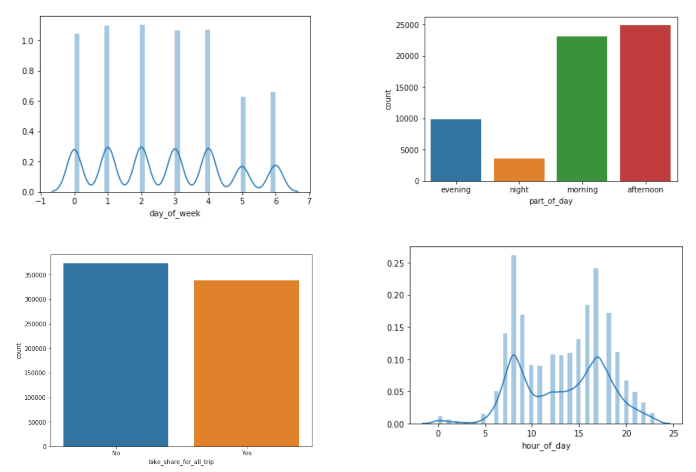

In the next section, we feed the data to Autopilot so that it can run an experiment for us.


## Build a binary classification model

Autopilot requires that we specify the input and output destination buckets. It uses the input bucket to load the data and the output bucket to save the artifacts, such as feature engineering and the generated Jupyter notebooks. We retain 5% of the dataset to evaluate and validate the model’s performance after the training is complete and upload 95% of the dataset to the S3 input bucket. See the following code:

In [ ]:
import sagemaker
import boto3

# Let's define our storage.
# We will use the default sagemaker bucket and will enforce encryption 
 
bucket = sagemaker.Session().default_bucket()  # SageMaker default bucket. 
#Encrypting the bucket
s3 = boto3.client('s3')
SSEConfig={
        'Rules': [
            {
                'ApplyServerSideEncryptionByDefault': {
                    'SSEAlgorithm': 'AES256',
                }
            },
        ]
    }
s3.put_bucket_encryption(Bucket=bucket, ServerSideEncryptionConfiguration=SSEConfig)

prefix = 'sagemaker-automl01'                  # prefix for ther bucket
role = sagemaker.get_execution_role()          # IAM role object to use by SageMaker
sagemaker_session = sagemaker.Session()        # Sagemaker API
region = sagemaker_session.boto_region_name    # AWS Region

# Where we will load our data 
input_path = "s3://{}/{}/automl_bike_train_share-1".format(bucket, prefix) 
output_path = "s3://{}/{}/automl_bike_output_share-1".format(bucket, prefix)

# Spliting data in train/test set.
# We will use 95% of the data for training and the remainder for testing.
slice_point = int(df.shape[0] * 0.95) 
training_set = df[:slice_point] # 95%
testing_set = df[slice_point:]  # 5%

# Just making sure we have split it correctly
assert training_set.shape[0] + testing_set.shape[0] == df.shape[0]

# Let's save the data locally and upload it to our s3 data location
training_set.to_csv('bike_train.csv')
testing_set.to_csv('bike_test.csv', header=False)

# Uploading file the trasining set to the input bucket
sagemaker.s3.S3Uploader.upload(local_path='bike_train.csv', desired_s3_uri=input_path)


After we upload the data to the input destination, it’s time to start Autopilot:

In [ ]:
from sagemaker.automl.automl import AutoML
# You give your job a name and provide the s3 path where you uploaded the data
bike_automl_binary = AutoML(role=role, 
                         target_attribute_name='bike_share_for_all_trip', 
                         output_path=output_path,
                         max_candidates=30)
# Starting the training 
from datetime import datetime as dt
today = str(dt.today())[:10]
bike_automl_binary.fit(inputs=input_path, 
                       wait=False, logs=False)

All we need to start experimenting is to call the fit() method. Autopilot needs the input and output S3 location and the target attribute column as the required parameters. After feature processing, Autopilot calls [SageMaker Automatic Model Tuning](https://docs.aws.amazon.com/sagemaker/latest/dg/automatic-model-tuning.html) to find the best version of a model by running many training jobs on your dataset. We added the optional max_candidates parameter to limit the number of candidates to 30, which is the number of training jobs that Autopilot launches with different combinations of algorithms and hyperparameters in order to find the best model. If you don’t specify this parameter, it defaults to 250.

We can observe the progress of Autopilot with the following code:

In [ ]:
# Let's monitor the progress this will take a while. Go grup some coffe.
from time import sleep

def check_job_status():
    status = bike_automl_binary.describe_auto_ml_job()['AutoMLJobStatus']
    return status

def discribe():
    return bike_automl_binary.describe_auto_ml_job()

while True:
    print (check_job_status(), discribe()['AutoMLJobSecondaryStatus'], end='** ') 
    if check_job_status() in ["Completed", "Failed"]:
        if "Failed" in check_job_status():
            print(discribe()['FailureReason'])
        break
    sleep(20)

The training takes some time to complete. While it’s running, let’s look at the Autopilot workflow.

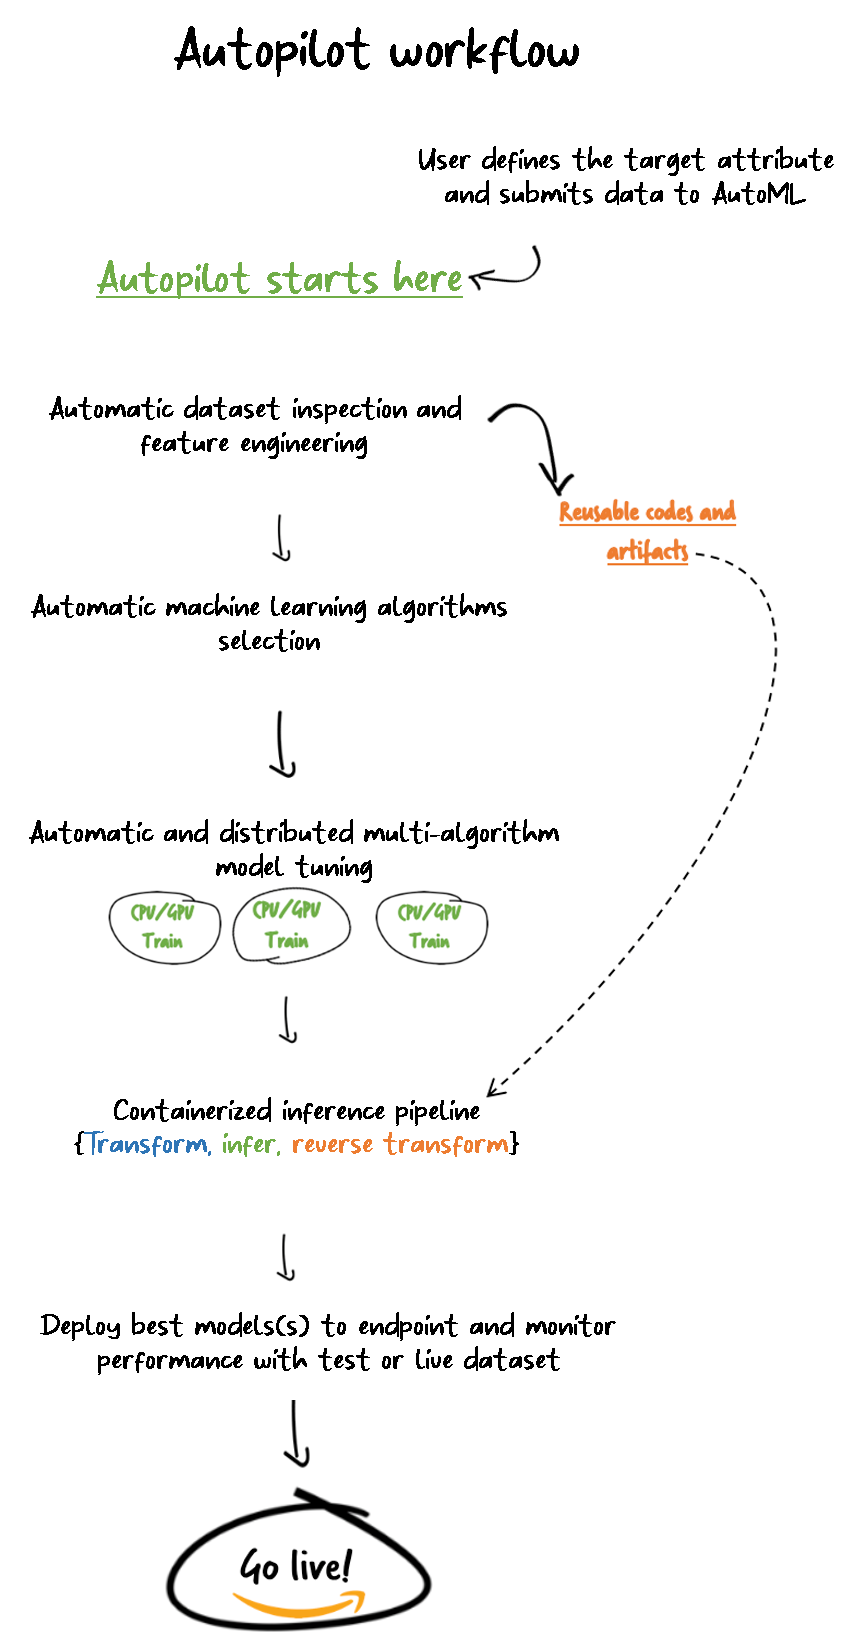

To find the best candidate, use the following code:

In [ ]:
# Let's take a look at the best candidate selected by AutoPilot
from IPython.display import JSON
def jsonView(obj, rootName=None):
    return JSON(obj, root=rootName, expanded=True)

bestCandidate = bike_automl_binary.describe_auto_ml_job()['BestCandidate']
display(jsonView(bestCandidate['FinalAutoMLJobObjectiveMetric'], 'FinalAutoMLJobObjectiveMetric'))

Our model achieved a validation accuracy of 96%, so we’re going to deploy it. We could add a condition such that we only use the model if the accuracy is above a certain level.

## Inference pipeline

Before we deploy our model, let’s examine our best candidate and what’s happening in our pipeline. See the following code:


In [ ]:
display(jsonView(bestCandidate['InferenceContainers'], 'InferenceContainers'))

Autopilot has built the model and has packaged it in three different containers, each sequentially running a specific task: transform, predict, and reverse-transform. This multi-step inference is possible with a [SageMaker inference pipeline.](https://docs.aws.amazon.com/sagemaker/latest/dg/inference-pipelines.html)

A multi-step inference can also chain multiple inference models. For instance, one container can perform [principal component analysis](https://en.wikipedia.org/wiki/Principal_component_analysis) before passing the data to the XGBoost container.

## Deploy the inference pipeline to an endpoint

The deployment process involves just a few lines of code:


In [ ]:
# We chose to difine an endpoint name.
endpoint_name='binary-bike-share-'  + today
endpoint = bike_automl_binary.deploy(initial_instance_count=1,
                                  instance_type='ml.m5.xlarge',
                                  endpoint_name=endpoint_name,
                                  candidate=bestCandidate,
                                  wait=True)

Let’s configure our endpoint for prediction with a predictor:

In [ ]:
#from sagemaker.content_types import CONTENT_TYPE_CSV, CONTENT_TYPE_JSON
from sagemaker.serializers import CSVSerializer
from sagemaker.deserializers import CSVDeserializer
csv_serializer = CSVSerializer()
csv_deserializer = CSVDeserializer()
# Initialize the predictor
predictor = sagemaker.predictor.Predictor(endpoint_name=endpoint_name, 
                                                  sagemaker_session=sagemaker.Session(),
                                                  serializer=csv_serializer,
                                                  deserializer=csv_deserializer
                                                  )

Now that we have our endpoint and predictor ready, it’s time to use the testing data we set aside and test the accuracy of our model. We start by defining a utility function that sends the data one line at a time to our inference endpoint and gets a prediction in return. Because we have an [XGBoost](https://docs.aws.amazon.com/sagemaker/latest/dg/xgboost.html) model, we drop the target variable before sending the CSV line to the endpoint. Additionally, we removed the header from the testing CSV before looping through the file, which is also another requirement for XGBoost on SageMaker. See the following code:

In [ ]:
# The fuction takes 3 arguments: the file containing the test set,
# The predictor and finaly the number of lines to send for prediction.
# The function returns two Series: inferred and Actual.
def get_inference(file, predictor, n=1):
    infered = []
    actual = []
    with open(file, 'r') as csv:
        for i in range(n):
            line = csv.readline().split(',')
            #print(line)
            try:
                # Here we remove the target variable from the csv line before predicting 
                observed = line.pop(14).strip('\n')
                actual.append(observed)
            except:
                pass
            obj = ','.join(line)
            
            predicted = predictor.predict(obj)[0][0]
            infered.append(predicted)
            pd.Series(infered)
            data = {'Infered': pd.Series(infered), 'Observed': pd.Series(actual)}
    return  pd.DataFrame(data=data)
    
n = testing_set.shape[0] # The size of the testing data
inference_df = get_inference('bike_test.csv', predictor, n)

inference_df['Binary_Result'] = (inference_df['Observed'] == inference_df['Infered'])
display(inference_df.head())

Now let’s calculate the accuracy of our model using the following formula:


<div>
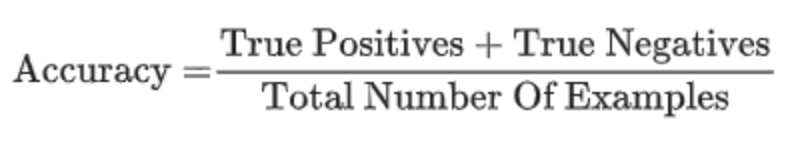
</div>
See the following code:

In [ ]:
count_binary = inference_df['Binary_Result'].value_counts()
accuracy = count_binary[True]/n
print('Accuracy:', accuracy)

We get an accuracy of 92%. This is slightly lower than the 96% obtained during the validation step, but it’s still high enough. We don’t expect the accuracy to be exactly the same because the test is performed with a new dataset.

## Clean up

It’s important to delete all the resources used in this exercise to minimize cost. The following code deletes the SageMaker inference endpoint we created as well the training and testing data we uploaded:

In [ ]:
#Delete the s3 data
predictor.delete_endpoint()

# Delete s3 data
s3 = boto3.resource('s3')
ml_bucket = sagemaker.Session().default_bucket()
delete_data = s3.Bucket(ml_bucket).objects.filter(Prefix=prefix).delete()

## Conclusion

ML engineers, data scientists, and software developers can use Autopilot to build and deploy an inference pipeline with little to no ML programming experience. Autopilot saves time and resources, using data science and ML best practices. Large organizations can now shift engineering resources away from infrastructure configuration towards improving models and solving business use cases. Startups and smaller organizations can get started on machine learning with little to no ML expertise.

We recommend learning more about other important features SageMaker has to offer, such as the [Amazon SageMaker Feature Store](https://aws.amazon.com/sagemaker/feature-store/), which integrates with [Amazon SageMaker Pipelines](https://aws.amazon.com/sagemaker/pipelines/) to create, add feature search and discovery, and reuse automated ML workflows. You can run multiple Autopilot simulations with different feature or target variants in your dataset. You could also approach this as a dynamic vehicle allocation problem in which your model tries to predict vehicle demand based on time (such as time of day or day of the week) or location, or a combination of both.

